<a href="https://colab.research.google.com/github/alex-escobar-h/Facial-Expression-Recognition-Model/blob/main/facial_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition

## Install FER-2013 Dataset from Kaggle

In [21]:
from google.colab import userdata
import os
import torch
import torch.nn as nn
import torch.optim as optim

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
!pip install -q kaggle
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Data Preparation and Transforms

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


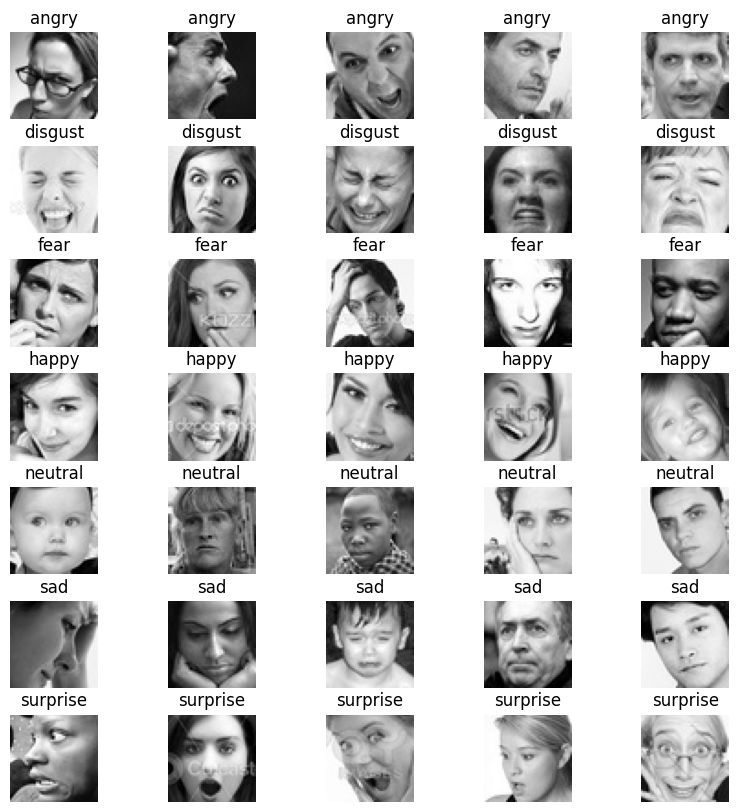

In [31]:
# import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

normalize = transforms.Normalize(mean=[0.5],std=[0.5])
batch_size = 64
num_workers = 0

# Define transforms
train_transform = transforms.Compose([
    transforms.Grayscale(),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(),
    # transforms.Resize((48,48)),
    transforms.ToTensor(),
    normalize
])

# Load datasets
train_dataset_full = datasets.ImageFolder(root='/content/train', transform=train_transform)

# Split training data into training and validation (80%/20%)
val_dataset_size = int(0.2*len(train_dataset_full))
train_dataset_size = len(train_dataset_full) - val_dataset_size

# Randomly split the full training dataset into 80% training and 20% validation subsets.
# The manual seed ensures reproducibility - the same split every time this code runs.
train_dataset, val_dataset = random_split(
    train_dataset_full,[train_dataset_size,val_dataset_size], generator=torch.Generator().manual_seed(42)
)

train_dataset.dataset.transform=train_transform
val_dataset.dataset.transform=val_test_transform

test_dataset = datasets.ImageFolder('/content/test', transform=val_test_transform)

# Wrap datasets in DataLoaders
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Retrieve classifications from training dataset
classes = train_dataset.dataset.classes
print(classes)

# Visualize training images
sample_num = 5
fig, axes = plt.subplots(nrows=len(classes), ncols=sample_num, figsize=(10,10))

for i, emotion in enumerate(classes):
    # Get all indices in train_dataset_full that belong to the current emotion
    indices = [idx for idx, (_, label) in enumerate(train_dataset_full.samples) if label == i]
    # Randomly sample indices for visualization
    sample_indices = random.sample(indices, sample_num)
    for j, idx in enumerate(sample_indices):
        img_path, _ = train_dataset_full.samples[idx]
        image = plt.imread(img_path)
        axes[i][j].imshow(image, cmap='gray')
        axes[i][j].set_title(emotion)
        axes[i][j].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

## CNN Model Class

In [23]:
# import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=20, out_channels=40, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=40, out_channels=80, kernel_size=3, padding=1
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)

        # After 3 conv + 3 pool layers:
        # 48 -> 24 -> 12 -> 6 -> final feature map size: [80, 6, 6]
        self.fc1 = nn.Linear(in_features=80 * 6 * 6, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=7)  # 7 emotion classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [20, 24, 24]
        x = self.pool(F.relu(self.conv2(x)))  # [40, 12, 12]
        x = self.pool(F.relu(self.conv3(x)))  # [80, 6, 6]

        x = x.view(-1, 80 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Training and Validation Loop

In [24]:
import torch.optim as optim
import numpy as np

model = CNN()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 5
valid_loss_min = np.inf  # track change in validation loss

for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # Train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)

    ######################
    # Validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(val_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(val_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_trained.pt')
        valid_loss_min = valid_loss

CUDA is available!  Training on GPU ...
Epoch: 1 	Training Loss: 1.659213 	Validation Loss: 1.487331
Validation loss decreased (inf --> 1.487331).  Saving model ...
Epoch: 2 	Training Loss: 1.420965 	Validation Loss: 1.344919
Validation loss decreased (1.487331 --> 1.344919).  Saving model ...
Epoch: 3 	Training Loss: 1.272000 	Validation Loss: 1.258382
Validation loss decreased (1.344919 --> 1.258382).  Saving model ...
Epoch: 4 	Training Loss: 1.150412 	Validation Loss: 1.259430
Epoch: 5 	Training Loss: 1.046291 	Validation Loss: 1.213931
Validation loss decreased (1.258382 --> 1.213931).  Saving model ...


## Testing

In [25]:
model.eval()

test_loss = 0.0
num_classes = len(classes)
class_correct = [0. for _ in range(num_classes)]
class_total = [0. for _ in range(num_classes)]

with torch.no_grad():
    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.view_as(pred))
        correct = correct_tensor.cpu().numpy() if train_on_gpu else correct_tensor.numpy()

        for i in range(len(target)):
            label = target[i].item()
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# Compute average loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# Print per-class accuracy
for i in range(num_classes):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print('Test Accuracy of %8s: %2d%% (%d/%d)' %
              (classes[i], int(acc), int(class_correct[i]), int(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no test examples)' % classes[i])

# Print overall accuracy
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.200166

Test Accuracy of    angry: 38% (371/958)
Test Accuracy of  disgust: 19% (22/111)
Test Accuracy of     fear: 20% (208/1024)
Test Accuracy of    happy: 83% (1479/1774)
Test Accuracy of  neutral: 45% (564/1233)
Test Accuracy of      sad: 52% (653/1247)
Test Accuracy of surprise: 73% (612/831)

Test Accuracy (Overall): 54% (3909/7178)
